In [53]:
from pathlib import Path
from datetime import datetime
import sys
import yaml
from time import time
import os
import copy
from geopy.geocoders import GoogleV3, Nominatim
import matplotlib.dates as mdates
from numpy import median

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from SCanalyzer.busSim.manager import LocalManager
from pyproj import Transformer

import matplotlib.pyplot as plt
from matplotlib import lines

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from shapely import geometry

%matplotlib inline

In [54]:
import math

def get_sigmoid(x):
    return 1/(1+math.e**(-x)) - 0.5

def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    # y = sqrt(x), sigmoid, saturated functions
    score = get_sigmoid(banks) + get_sigmoid(clinics) + get_sigmoid(hospitals) + get_sigmoid(dentists) + get_sigmoid(supermarkets)
    return score

In [55]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'mmt_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


In [56]:
# the number of each building in each census block
new_census = census_gdf.copy(True)
new_census['banks'] = 0
new_census['clinics'] = 0
new_census['dentists'] = 0
new_census['hospitals'] = 0
new_census['supermarket'] = 0
for idx, row in new_census.bounds.iterrows():
    for _, service in services_gdf.iterrows():
        if row['miny'] <= service['latitude'] <= row['maxy'] and row['minx'] <= service['longitude'] <= row['maxx']:
            new_census.loc[idx, service['service']] += 1
new_census['score'] = new_census.apply(axis=1, func=lambda row: get_score(0, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket']))

/var/folders/v_/6c5ts29s0gd2d_5_syjrk88c0000gn/T/ipykernel_54800/1185873198.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  polys = [[p.x, p.y] for p in new_census.centroid]


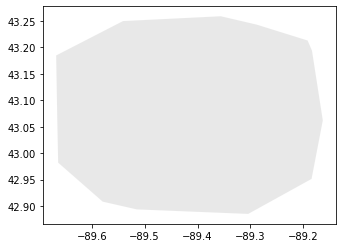

In [57]:
# polys = [[p.x, p.y] for p in new_census.centroid]
# ax = gpd.GeoSeries(geometry.Polygon(polys).convex_hull).plot(color="lightgrey", alpha=0.5)

In [58]:
new_census_sorted = new_census[new_census['score'] != 0].sort_values('score')
points_low = new_census_sorted.head(10)
points_high = new_census_sorted.tail(10)

In [59]:
points = {"low": [(p.y, p.x) for p in points_low.centroid],
    "high": [(p.y, p.x) for p in points_high.centroid]}

/var/folders/v_/6c5ts29s0gd2d_5_syjrk88c0000gn/T/ipykernel_54800/724660934.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = {"low": [(p.y, p.x) for p in points_low.centroid],
/var/folders/v_/6c5ts29s0gd2d_5_syjrk88c0000gn/T/ipykernel_54800/724660934.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  "high": [(p.y, p.x) for p in points_high.centroid]}


In [62]:
def flatten(s, crs):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union]), 'crs': crs})

def gen_busSim(data_path=None, out_path=None, day=None, start_time=None, elapse_time=None, avg_walking_speed=None, max_walking_min=None):
    manager = LocalManager(data_path, out_path, None)
    busSim = BusSim(manager, day, start_time, elapse_time, avg_walking_speed, max_walking_min)
    return busSim

def get_area(start_points=[], start_locations=[], busSim=None, crs=None, city=None):
    if len(start_points)==0:
        geolocator = Nominatim(user_agent="user_test")
        for loc in start_locations:
            location = geolocator.geocode(loc)
            print(location)
            start_point = (location.latitude, location.longitude)
            start_points.append(start_point)
    
    area_dict = {}
    # print(f'{start_points=}')
    for index, start in enumerate(start_points):
        # print(f'{start=}')
        gdf = busSim.get_gdf(start_point=start)
        busSim.clear_graph()
        if gdf is None:
            area_dict[f'{start_points[index]}'] = 0
            continue
        gdf = gdf.to_crs(epsg=crs)
        bubble = flatten(gdf.geometry, crs)
        new_census2 = new_census.to_crs(crs).intersection(bubble.unary_union)
        new_census2 = gpd.GeoDataFrame(geometry=new_census2, crs=crs)
        new_census2['score'] = new_census['score']
        # print(f'{new_census2.head()=}')
        area_dict[f'{start_points[index]}'] = new_census2[~new_census2['geometry'].is_empty]['score'].sum()
    # print(f'{area_dict=}')
    return area_dict

def draw_area_times(times, areas, data_path, results):
    fig, ax = plt.subplots(figsize=(12,8)) 
    times = list(map(lambda x: datetime.strptime(x.capitalize(), "%A %H:%M:%S  %d"), times))
    formatter = mdates.DateFormatter("%a %H:%M")
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate()
    
    for key in areas.keys():
        # print(f'loc {key}')
        # print(f'{areas[key]=}')
        # print(f'min value: {min(areas[key])}')
        results['min coverage'].append(min(areas[key]))
        results['max coverage'].append(max(areas[key]))
        results['median coverage'].append(median(areas[key]))
        # print(f'max value: {max(areas[key])}')
        geoloctor = Nominatim(user_agent="reverse_user")
        info = geoloctor.reverse(key[1:-1]).raw
        if info != None:
            info = info['address']
            addr = ''
            for index, addrkey in enumerate(info):
                if index > 1:
                    break
                addr += " " + info[addrkey]
        else:
            addr = key
        ax.plot(times, areas[key], label = addr)
        results['label'].append(addr)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel("score", fontsize=18)
    plt.title('Score vs Time', fontsize=20)
    plt.legend()
    plt.savefig('mearsurement_plot.png')

def run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results):
    prog_start = time()
    areas = {}
    for start_time in start_times:
        # print('creat busSim')
        day, start = start_time.split(' ')
        busSim = gen_busSim(DATA_PATH,OUT_PATH, day, start, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
        # print('cal area')
        for key, area in get_area(start_points=START_POINTS, start_locations=START_LOCATIONS, busSim=busSim, crs=crs).items():
            if key not in areas:
                areas[key] = []
                areas[key].append(float(area))
            else:
                areas[key].append(float(area))
    # print(f'{areas=}')
    pre_day = ''
    day_index = 0
    for index in range(len(start_times)):
        day, start = start_times[index].split(' ')
        if pre_day != day:
            day_index+=1
            pre_day = day
        start_times[index] = f"{start_times[index]}  {day_index}"
        
    print(start_times)
    draw_area_times(start_times, areas, DATA_PATH, results)
    duration = time() - prog_start
    # results['time'].append(duration)
    print(f'time taken {duration}')
    return duration

In [ ]:
start_points_dict = points
results = {
    "label":[],
    "max coverage": [],
    "min coverage": [],
    "median coverage": []
}

print(f'{len(start_points_dict["low"])=}')
START_POINTS = start_points_dict['low']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 3174
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(7,22,1):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))

len(start_points_dict["high"])=10
stops_meter exists
['monday 07:00:00  1', 'monday 10:00:00  1', 'monday 13:00:00  1', 'monday 16:00:00  1', 'monday 19:00:00  1', 'tuesday 07:00:00  2', 'tuesday 10:00:00  2', 'tuesday 13:00:00  2', 'tuesday 16:00:00  2', 'tuesday 19:00:00  2', 'wednesday 07:00:00  3', 'wednesday 10:00:00  3', 'wednesday 13:00:00  3', 'wednesday 16:00:00  3', 'wednesday 19:00:00  3', 'thursday 07:00:00  4', 'thursday 10:00:00  4', 'thursday 13:00:00  4', 'thursday 16:00:00  4', 'thursday 19:00:00  4', 'friday 07:00:00  5', 'friday 10:00:00  5', 'friday 13:00:00  5', 'friday 16:00:00  5', 'friday 19:00:00  5', 'saturday 07:00:00  6', 'saturday 10:00:00  6', 'saturday 13:00:00  6', 'saturday 16:00:00  6', 'saturday 19:00:00  6', 'sunday 07:00:00  7', 'sunday 10:00:00  7', 'sunday 13:00:00  7', 'sunday 16:00:00  7', 'sunday 19:00:00  7']
time taken 92.30524492263794


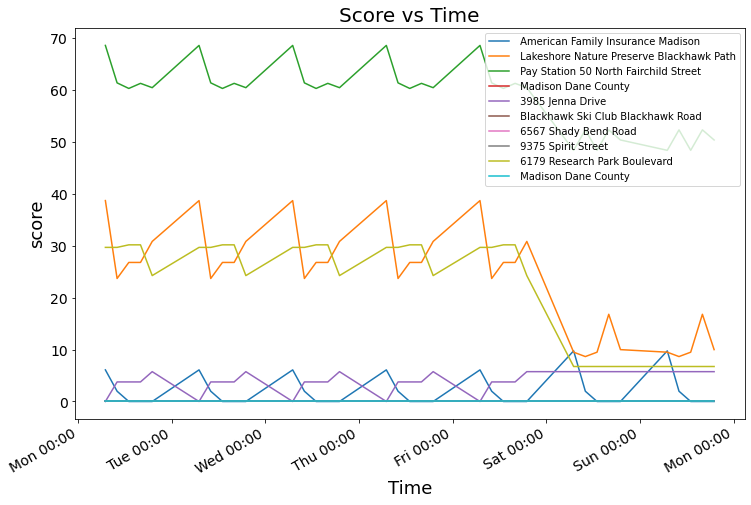

In [65]:
start_points_dict = points
results = {
    "label":[],
    "max coverage": [],
    "min coverage": [],
    "median coverage": []
}

print(f'{len(start_points_dict["high"])=}')
START_POINTS = start_points_dict['high']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 3174
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(7,22,3):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))

In [68]:
print(pd.DataFrame(results).to_markdown())

|    | label                            |   max coverage |   min coverage |   median coverage |
|---:|:---------------------------------|---------------:|---------------:|------------------:|
|  0 | South Gammon Road Madison        |        7.61976 |        7.61976 |           7.61976 |
|  1 | 412 North Carroll Street         |       68.5807  |       46.3927  |          60.4444  |
|  2 | 2668 Mason Street                |       56.6917  |       31.6304  |          49.0547  |
|  3 | 7105 Prairie Drive               |       20.2606  |        5.32072 |          15.354   |
|  4 | 6968 Winstone Drive              |        6.35908 |        6.35908 |           6.35908 |
|  5 | 5318 Golden Leaf Trail           |        2.05761 |        2.05761 |           2.05761 |
|  6 | 465 Davies Street                |       23.4478  |        7.42925 |           8.27217 |
|  7 | Sandburg Woods Bike Path Madison |       10.3654  |        5.2968  |           9.75352 |
|  8 | 1536 South Whitney Way           

len(start_points_dict["low"])=10
stops_meter exists
['monday 07:00:00  1', 'monday 10:00:00  1', 'monday 13:00:00  1', 'monday 16:00:00  1', 'monday 19:00:00  1', 'tuesday 07:00:00  2', 'tuesday 10:00:00  2', 'tuesday 13:00:00  2', 'tuesday 16:00:00  2', 'tuesday 19:00:00  2', 'wednesday 07:00:00  3', 'wednesday 10:00:00  3', 'wednesday 13:00:00  3', 'wednesday 16:00:00  3', 'wednesday 19:00:00  3', 'thursday 07:00:00  4', 'thursday 10:00:00  4', 'thursday 13:00:00  4', 'thursday 16:00:00  4', 'thursday 19:00:00  4', 'friday 07:00:00  5', 'friday 10:00:00  5', 'friday 13:00:00  5', 'friday 16:00:00  5', 'friday 19:00:00  5', 'saturday 07:00:00  6', 'saturday 10:00:00  6', 'saturday 13:00:00  6', 'saturday 16:00:00  6', 'saturday 19:00:00  6', 'sunday 07:00:00  7', 'sunday 10:00:00  7', 'sunday 13:00:00  7', 'sunday 16:00:00  7', 'sunday 19:00:00  7']
time taken 103.21278190612793


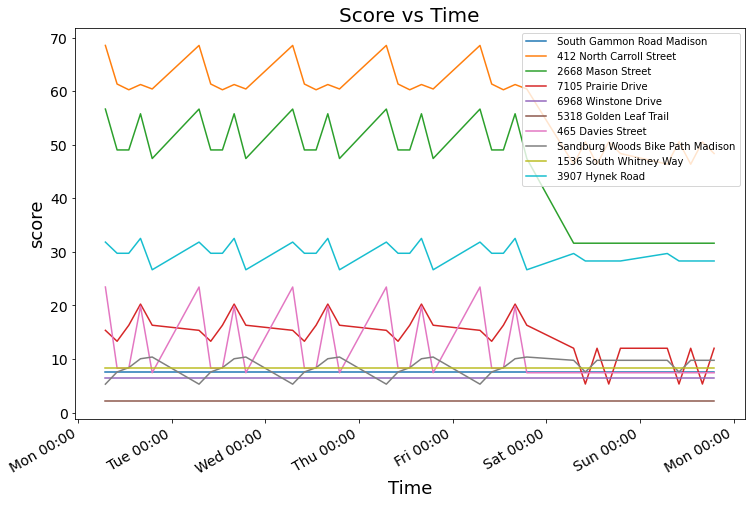

In [66]:
start_points_dict = points
results = {
    "label":[],
    "max coverage": [],
    "min coverage": [],
    "median coverage": []
}

print(f'{len(start_points_dict["low"])=}')
START_POINTS = start_points_dict['low']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/mmt_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = 3174
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
# days = ["monday"]
for day in days:
    for start_time in range(7,22,3):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))

In [69]:
print(pd.DataFrame(results).to_markdown())

|    | label                            |   max coverage |   min coverage |   median coverage |
|---:|:---------------------------------|---------------:|---------------:|------------------:|
|  0 | South Gammon Road Madison        |        7.61976 |        7.61976 |           7.61976 |
|  1 | 412 North Carroll Street         |       68.5807  |       46.3927  |          60.4444  |
|  2 | 2668 Mason Street                |       56.6917  |       31.6304  |          49.0547  |
|  3 | 7105 Prairie Drive               |       20.2606  |        5.32072 |          15.354   |
|  4 | 6968 Winstone Drive              |        6.35908 |        6.35908 |           6.35908 |
|  5 | 5318 Golden Leaf Trail           |        2.05761 |        2.05761 |           2.05761 |
|  6 | 465 Davies Street                |       23.4478  |        7.42925 |           8.27217 |
|  7 | Sandburg Woods Bike Path Madison |       10.3654  |        5.2968  |           9.75352 |
|  8 | 1536 South Whitney Way           